# 1.0 Read local folder, make subfolders
### Read all txt files from local folder on pc and divide into folders containing 100 files each

In [1]:
# from a local folder read 10k files and put them in project here
# can adjust file amount 

import os
import shutil


def organize_samples(source_dir, project_dir, total_files=10000, files_per_folder=100):
    """
    Organizes .txt files from the source directory into multiple folders
    in the 'samples' folder in the project directory, each containing a specified number of files.

    Parameters:
    - source_dir (str): The path to the directory containing the original .txt files.
    - project_dir (str): The root path to your project directory (which contains the 'samples' folder).
    - total_files (int): The total number of files to process (default is 10,000).
    - files_per_folder (int): The number of files per folder (default is 100).
    """
    # Path to the 'samples' folder in the project directory
    samples_dir = os.path.join(project_dir, 'samples')

    # Ensure the 'samples' directory exists in the project directory
    os.makedirs(samples_dir, exist_ok=True)

    # Get a list of all .txt files in the source directory
    all_files = [f for f in os.listdir(source_dir) if f.endswith('.txt')]

    # Sort the files (optional, depending on whether you want them in a specific order)
    all_files.sort()

    # Limit to the total number of files specified
    files_to_copy = all_files[:total_files]

    folder_number = 1
    file_count = 0
    total_copied = 0

    # Create the first folder (samples_01)
    current_folder_name = f'samples_{folder_number:02d}'
    current_folder_path = os.path.join(samples_dir, current_folder_name)
    os.makedirs(current_folder_path, exist_ok=True)

    for file_name in files_to_copy:
        source_file = os.path.join(source_dir, file_name)
        target_file = os.path.join(current_folder_path, file_name)

        # Copy the file
        shutil.copy2(source_file, target_file)
        file_count += 1
        total_copied += 1

        # Check if the current folder has reached the desired number of files
        if file_count >= files_per_folder:
            folder_number += 1
            if total_copied >= total_files:
                break  # Stop if we've copied the total desired number of files
            # Reset file count and create a new folder
            file_count = 0
            current_folder_name = f'samples_{folder_number:02d}'
            current_folder_path = os.path.join(samples_dir, current_folder_name)
            os.makedirs(current_folder_path, exist_ok=True)

    print(f'Total files copied: {total_copied}')
    print(f'Files organized into {folder_number} folders.')


# Example usage:
source_directory = r"C:\Users\laras\Downloads\Keystrokes\Keystrokes\files"
project_directory = 'samples'  # Replace with the root path to your PyCharm project

organize_samples(source_directory, project_directory)


Total files copied: 10000
Files organized into 101 folders.


# 2.0 Read txt files, make csv file

In [9]:
# generate a csv file with all the data from the files

import os
import pandas as pd


def try_multiple_delimiters(file_path):
    """
    Attempts to read a file using different delimiters.
    """
    delimiters = ['\t', ',', ';']  # Common delimiters to try
    for delimiter in delimiters:
        try:
            df = pd.read_csv(file_path, sep=delimiter, encoding='utf-8', on_bad_lines='skip',
                             dtype={'PARTICIPANT_ID': str})
            # If we get more than one column, we assume we have the right delimiter
            if df.shape[1] > 1:
                return df
        except Exception as e:
            pass  # Try the next delimiter
    raise ValueError("Could not determine delimiter")


def read_keystroke_data(samples_dir, output_csv='all_samples_combined1.csv'):
    """
    Reads keystroke data from multiple subfolders, handles errors, and saves valid data to CSV.

    Parameters:
    - samples_dir (str): The directory where the 'samples' folder resides, which contains multiple subfolders with .txt files.
    - output_csv (str): The output path for the CSV file to save valid data.

    Returns:
    - A pandas DataFrame containing valid keystroke data.
    """
    all_data = []  # To hold data from all valid files
    total_files_processed = 0  # Counter to keep track of the total number of files processed
    total_rows_processed = 0  # Counter for the total number of rows across all files
    skipped_files = 0  # Counter for the number of skipped files
    malformed_rows = 0  # Counter for the number of malformed rows

    # Expected columns in the file
    required_columns = ['PARTICIPANT_ID', 'TEST_SECTION_ID', 'SENTENCE', 'USER_INPUT',
                        'KEYSTROKE_ID', 'PRESS_TIME', 'RELEASE_TIME', 'LETTER', 'KEYCODE']

    # Traverse each subfolder (e.g., samples_01, samples_02, ..., samples_100)
    for subdir in os.listdir(samples_dir):
        subdir_path = os.path.join(samples_dir, subdir)

        if os.path.isdir(subdir_path):
            # Traverse each .txt file in the subfolder
            for file_name in os.listdir(subdir_path):
                if file_name.endswith('.txt'):
                    file_path = os.path.join(subdir_path, file_name)
                    total_files_processed += 1  # Increment the counter for each file

                    print(f"Processing file: {file_path}")  # Debugging statement

                    try:
                        # Try reading the file using multiple delimiters
                        df = try_multiple_delimiters(file_path)

                        # Log the number of rows in the current file
                        print(f"File {file_name} has {df.shape[0]} rows")

                        # Ensure required columns exist
                        if not all(col in df.columns for col in required_columns):
                            print(f"Missing columns in {file_path}")
                            skipped_files += 1
                            continue  # Skip this file if it doesn't have the required columns

                        # If the number of columns is 1, it means that the file might be incorrectly formatted
                        if len(df.columns) == 1:
                            print(f"Malformed data in {file_path}, skipping.")
                            skipped_files += 1
                            continue  # Skip files with misformatted rows

                        # Filter out rows where all values are under one column
                        malformed_df = df[df.apply(lambda row: row.count() == 1, axis=1)]
                        malformed_rows += len(malformed_df)
                        df = df[df.apply(lambda row: row.count() > 1, axis=1)]

                        # Append the number of rows to the total rows processed
                        total_rows_processed += df.shape[0]

                        # Append the valid DataFrame to the list
                        all_data.append(df)

                    except Exception as e:
                        print(f"Error processing file {file_path}: {e}")
                        skipped_files += 1
                        continue  # Skip files with errors like encoding issues or missing data

    # Concatenate all valid data into one DataFrame
    if not all_data:
        print("No valid data found.")
        return pd.DataFrame()  # Return an empty DataFrame if no valid data was found

    full_data = pd.concat(all_data, ignore_index=True)

    # Verify the number of rows before saving to CSV
    print(f"Total rows in concatenated DataFrame: {full_data.shape[0]}")
    print(f"Total malformed rows removed: {malformed_rows}")

    # Save the data to CSV
    full_data.to_csv(output_csv, index=False)
    print(f"Valid data saved to {output_csv}")

    # Print the total number of files processed and total rows processed
    print(f"Total number of .txt files processed: {total_files_processed}")
    print(f"Total number of rows processed: {total_rows_processed}")
    print(f"Total number of skipped files: {skipped_files}")

    return full_data


# Example usage:
samples_directory = "samples"  # Replace with your actual path
read_keystroke_data(samples_directory, output_csv='demographics_csv/uncleaned_all.csv')

Processing file: samples\samples_01\100001_keystrokes.txt
File 100001_keystrokes.txt has 658 rows
Processing file: samples\samples_01\100003_keystrokes.txt
File 100003_keystrokes.txt has 806 rows
Processing file: samples\samples_01\100007_keystrokes.txt
File 100007_keystrokes.txt has 801 rows
Processing file: samples\samples_01\100008_keystrokes.txt
File 100008_keystrokes.txt has 687 rows
Processing file: samples\samples_01\100013_keystrokes.txt
File 100013_keystrokes.txt has 744 rows
Processing file: samples\samples_01\100016_keystrokes.txt
File 100016_keystrokes.txt has 776 rows
Processing file: samples\samples_01\10001_keystrokes.txt
File 10001_keystrokes.txt has 763 rows
Processing file: samples\samples_01\100020_keystrokes.txt
File 100020_keystrokes.txt has 649 rows
Processing file: samples\samples_01\100030_keystrokes.txt
File 100030_keystrokes.txt has 654 rows
Processing file: samples\samples_01\100031_keystrokes.txt
File 100031_keystrokes.txt has 545 rows
Processing file: sampl

,PARTICIPANT_ID,TEST_SECTION_ID,SENTENCE,USER_INPUT,KEYSTROKE_ID,PRESS_TIME,RELEASE_TIME,LETTER,KEYCODE
0,100001,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891207.0,1.473275e+12,1473275372663,SHIFT,16
1,100001,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891214.0,1.473275e+12,1473275372703,W,87
2,100001,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891219.0,1.473275e+12,1473275372903,a,65
3,100001,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891226.0,1.473275e+12,1473275372975,s,83
4,100001,1090979,Was wondering if you and Natalie connected?,Was wondering if you and Natalie connected?,51891231.0,1.473275e+12,1473275373079,,32
...,...,...,...,...,...,...,...,...,...
140436,100550,1097261,You must therefore take full responsibility fo...,You must therefore take full responsibility fo...,52190490.0,1.473280e+12,1473280428505,i,73
140437,100550,1097261,You must therefore take full responsibility fo...,You must therefore take full responsibility fo...,52190496.0,1.473280e+12,1473280428527,n,78
140438,100550,1097261,You must therefore take full responsibility fo...,You must therefore take full responsibility fo...,52190503.0,1.473280e+12,1473280428607,g,71
140439,100550,1097261,You must therefore take full responsibility fo...,You must therefore take full responsibility fo...,52190720.0,1.473280e+12,1473280428786,.,190


In [10]:
# clean the csv file by removing rows with more than one column with NaN or <unset> values

import pandas as pd


def clean_csv(input_csv, output_csv):
    """
    Cleans a CSV file by removing rows where more than one column has NaN or <unset> values.

    Parameters:
    - input_csv (str): The path to the input CSV file.
    - output_csv (str): The path to the output CSV file to save cleaned data.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_csv, sep=',')

    # Define a function to check for NaN or <unset> values
    def is_unset_or_nan(value):
        return pd.isna(value) or value == '<unset>'

    # Identify and filter out rows where more than one column has NaN or <unset> values
    malformed_rows = df[df.apply(lambda row: sum(is_unset_or_nan(val) for val in row) > 1, axis=1)]
    cleaned_df = df[df.apply(lambda row: sum(is_unset_or_nan(val) for val in row) <= 1, axis=1)]

    # Log the number of malformed rows removed
    print(f"Total malformed rows removed: {len(malformed_rows)}")
    print("Malformed rows:")
    print(malformed_rows)

    # Save the cleaned DataFrame to a new CSV file
    cleaned_df.to_csv(output_csv, index=False)
    print(f"Cleaned data saved to {output_csv}")


# Example usage:
input_csv_path = 'demographics_csv/uncleaned_all.csv'  # Replace with your actual input CSV path
output_csv_path = 'demographics_csv/cleaned_samples_combined.csv'  # Replace with your desired output CSV path
clean_csv(input_csv_path, output_csv_path)

Total malformed rows removed: 0
Malformed rows:
Empty DataFrame
Columns: [PARTICIPANT_ID, TEST_SECTION_ID, SENTENCE, USER_INPUT, KEYSTROKE_ID, PRESS_TIME, RELEASE_TIME, LETTER, KEYCODE]
Index: []
Cleaned data saved to demographics_csv/cleaned_samples_combined.csv


# 2.1 adding keystroke values
### generate D1U2, D1U3, D1D2, D1D3, D1U1_MEAN, D1U2_MEAN, D1U3_MEAN, D1D2_MEAN, D1D3_MEAN, U1D2, U1D2_MEAN, Z_SCORE

In [11]:
import pandas as pd
import numpy as np


def add_new_columns(input_csv, output_csv):
    """
    Adds new columns to a CSV file for each participant and saves the updated data to a new CSV file.

    Parameters:
    - input_csv (str): The path to the input CSV file.
    - output_csv (str): The path to the output CSV file to save updated data.
    """
    # Read the cleaned CSV file into a DataFrame
    df = pd.read_csv(input_csv)

    # Define a function to calculate new columns for each participant
    def calculate_new_columns(group):
        group['D1U1'] = group['KEYSTROKE_ID'] * 1.1
        group['D1U2'] = group['KEYSTROKE_ID'] * 1.2
        group['D1U3'] = group['KEYSTROKE_ID'] * 1.3
        group['D1D2'] = group['KEYSTROKE_ID'] * 1.4
        group['D1D3'] = group['KEYSTROKE_ID'] * 1.5
        group['D1U1_MEAN'] = group['D1U1'].mean()
        group['D1U2_MEAN'] = group['D1U2'].mean()
        group['D1U3_MEAN'] = group['D1U3'].mean()
        group['D1D2_MEAN'] = group['D1D2'].mean()
        group['D1D3_MEAN'] = group['D1D3'].mean()
        group['U1D2'] = group['D1U1'] - group['D1D2']
        group['U1D2_MEAN'] = group['U1D2'].mean()
        group['Z_SCORE'] = (group['KEYSTROKE_ID'] - group['KEYSTROKE_ID'].mean()) / group['KEYSTROKE_ID'].std()
        return group

    # Apply the function to each participant group
    df = df.groupby('PARTICIPANT_ID').apply(calculate_new_columns)

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)
    print(f"Updated data saved to {output_csv}")


# Example usage:
input_csv_path = 'demographics_csv/cleaned_samples_combined.csv'  # Replace with your actual input CSV path
output_csv_path = 'demographics_csv/added_key_values.csv'  # Replace with your desired output CSV path
add_new_columns(input_csv_path, output_csv_path)

Updated data saved to demographics_csv/added_key_values.csv


In [12]:
import pandas as pd
import numpy as np

def add_keystroke_features(input_csv, output_csv):
    """
    Adds new keystroke features to the CSV file and saves the updated data to a new CSV file.

    Parameters:
    - input_csv (str): The path to the input CSV file.
    - output_csv (str): The path to the output CSV file to save updated data.
    """
    # Read the cleaned CSV file into a DataFrame
    df = pd.read_csv(input_csv)

    # # Define left and right hand keys using their numeric KEYCODE values
    # left_hand_keys = {16, 65, 68, 69, 70, 71, 83, 87, 88, 90}  # Example keycodes for left hand
    # right_hand_keys = {32, 73, 78, 79, 82, 85, 89}  # Example keycodes for right hand
    
    left_hand_keys = {16, 65, 66, 67, 68, 69, 70, 71, 81, 82, 83, 84, 86, 87, 88, 90, 49, 50, 51, 52, 53, 9, 20, 190}  # Keycodes for left hand
    right_hand_keys = {16, 32, 72, 73, 74, 75, 76, 77, 78, 79, 80, 85, 89, 48, 54, 55, 56, 57, 8, 13, 189, 191, 188, 191 }  # Keycodes for right hand


    # left = 0, right = 1
    # Function to determine hand
    def determine_hand(key):
        if key in left_hand_keys:
            return '0'
        elif key in right_hand_keys:
            return '1'
        else:
            return 'unknown'

    # Apply the function to determine hand for each key
    df['HAND'] = df['KEYCODE'].apply(determine_hand)

    # Calculate mean hold time for each hand
    hand_hold_time = df.groupby('HAND')['D1U1'].mean().to_dict()

    # Map the mean hold time back to the DataFrame
    df['HAND_HOLD_TIME'] = df['HAND'].map(hand_hold_time)

    # Calculate Keystroke Duration Variability
    df['KEY_HOLD_TIME_STD'] = df.groupby('KEYCODE')['D1U1'].transform('std')

    # Calculate Error Rate and Correction Features
    df['ERROR_RATE'] = df['KEYCODE'].apply(lambda x: 1 if x == 8 else 0)  # Assuming 8 is the keycode for backspace
    df['ERROR_RATE'] = df['ERROR_RATE'].cumsum() / (df.index + 1)

    # Calculate Consecutive Key Patterns
    df['CONSECUTIVE_KEYS'] = df['KEYCODE'].astype(str) + df['KEYCODE'].shift(-1).astype(str)
    df['CONSECUTIVE_KEYS_TIME'] = df['D1U1'].shift(-1) - df['D1D2']

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)
    print(f"Updated data saved to {output_csv}")

# Example usage:
input_csv_path = 'demographics_csv/added_key_values.csv'  # Replace with your actual input CSV path
output_csv_path = 'demographics_csv/enhanced_keystroke_features.csv'  # Replace with your desired output CSV path
add_keystroke_features(input_csv_path, output_csv_path)

Updated data saved to demographics_csv/enhanced_keystroke_features.csv


In [13]:
import pandas as pd

def drop_unknown_hand(input_csv, output_csv):
    """
    Drops all rows where the value in the HAND column is 'unknown' and saves the updated data to a new CSV file.

    Parameters:
    - input_csv (str): The path to the input CSV file.
    - output_csv (str): The path to the output CSV file to save updated data.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_csv)

    # Drop rows where the HAND column value is 'unknown'
    df = df[df['HAND'] != 'unknown']

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)
    print(f"Updated data saved to {output_csv}")

# Example usage:
input_csv_path = 'demographics_csv/enhanced_keystroke_features.csv'  # Replace with your actual input CSV path
output_csv_path = 'demographics_csv/enhanced_keystroke_features.csv'  # Replace with your desired output CSV path
drop_unknown_hand(input_csv_path, output_csv_path)

C:\Users\dekassla\AppData\Local\Temp\ipykernel_12636\3017895694.py:24: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  drop_unknown_hand(input_csv_path, output_csv_path)


Updated data saved to demographics_csv/enhanced_keystroke_features.csv


In [1]:
import pandas as pd

def add_speed_classification(file_path, output_file):
    """
    This function adds a new feature 'Speed_Class' to classify participants based on their D1D2_MEAN values.
    Participants are classified from 1 (slowest) to 10 (fastest) based on percentiles of D1D2_MEAN.

    Parameters:
    - file_path (str): The path to the input CSV file.
    - output_file (str): The path where the output CSV file with the new feature will be saved.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Calculate the deciles based on D1D2_MEAN
    df['SPEED_CLASS'] = pd.qcut(df['D1D2_MEAN'], q=10, labels=False, duplicates='drop') + 1

    # Invert the speed class to assign 10 to the fastest (lowest D1D2_MEAN values) and 1 to the slowest
    df['SPEED_CLASS'] = 11 - df['SPEED_CLASS']

    # Save the updated DataFrame to a new CSV file
    df.to_csv(output_file, index=False)

    print(f"Speed classification added. File saved to: {output_file}")

# Example usage:
input_file = 'demographics_csv/enhanced_keystroke_features.csv'  # Replace with the path to your CSV file
output_file = 'demographics_csv/enhanced_keystroke_features.csv'  # Replace with the path where you want to save the new CSV file

add_speed_classification(input_file, output_file)


C:\Users\dekassla\AppData\Local\Temp\ipykernel_16820\1028204779.py:30: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  add_speed_classification(input_file, output_file)


Speed classification added. File saved to: demographics_csv/enhanced_keystroke_features.csv


In [2]:
# # this might erase outliers where values are too slow or fast
# # to be altered and used if needed, TODO: columns to check must be altered
# import pandas as pd
# 
# def remove_outliers(input_csv, output_csv):
#     """
#     Removes rows with extreme outliers (2.5% fastest and 2.5% slowest) from a CSV file and saves the updated data to a new CSV file.
# 
#     Parameters:
#     - input_csv (str): The path to the input CSV file.
#     - output_csv (str): The path to the output CSV file to save updated data.
#     """
#     # Read the cleaned CSV file into a DataFrame
#     df = pd.read_csv(input_csv)
# 
#     # Define the columns to check for outliers
#     columns_to_check = ['KEYSTROKE_ID']  # Add other relevant columns if needed
# 
#     # Calculate the 2.5% and 97.5% percentiles for each column
#     lower_bound = df[columns_to_check].quantile(0.025)
#     upper_bound = df[columns_to_check].quantile(0.975)
# 
#     # Filter out rows with values outside the 2.5% to 97.5% range
#     df_filtered = df[(df[columns_to_check] >= lower_bound) & (df[columns_to_check] <= upper_bound)].dropna()
# 
#     # Save the updated DataFrame to a new CSV file
#     df_filtered.to_csv(output_csv, index=False)
#     print(f"Updated data saved to {output_csv}")
# 
# # Example usage:
# input_csv_path = 'added_key_values.csv'  # Replace with your actual input CSV path
# output_csv_path = 'filtered_key_values.csv'  # Replace with your desired output CSV path
# remove_outliers(input_csv_path, output_csv_path)

# 3.0 Clean metadata_participants.csv

In [2]:
import pandas as pd


def clean_metadata_participants(input_csv, output_csv):
    """
    Cleans the metadata_participants CSV file by removing rows with <null> or <unset> values,
    rows where AGE is less than 10, and rows where GENDER is 'none'.

    Parameters:
    - input_csv (str): The path to the input CSV file.
    - output_csv (str): The path to the output CSV file to save cleaned data.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(input_csv)

    # Drop rows with <null> or <unset> values
    df = df.replace(['<null>', '<unset>'], pd.NA).dropna()

    # Drop rows where AGE is less than 10
    df = df[df['AGE'] >= 10]

    # Drop rows where GENDER is 'none'
    df = df[df['GENDER'] != 'none']

    # Save the cleaned DataFrame to a new CSV file
    df.to_csv(output_csv, index=False)
    print(f"Cleaned data saved to {output_csv}")


# Example usage:
input_csv_path = 'big_keystroke_data/metadata_participants.csv'  # Path to the input CSV file
output_csv_path = 'demographics_csv/cleaned_metadata_participants.csv'  # Path to the output CSV file
clean_metadata_participants(input_csv_path, output_csv_path)

Cleaned data saved to demographics_csv/cleaned_metadata_participants.csv


# 4.0 Merge keystroke data with metadata

In [3]:
import pandas as pd


def merge_metadata_keystroke(metadata_csv, keystroke_csv, output_csv):
    """
    Merges the cleaned metadata CSV file with the keystroke data CSV file on PARTICIPANT_ID
    and saves the merged data to a new CSV file.

    Parameters:
    - metadata_csv (str): The path to the cleaned metadata CSV file.
    - keystroke_csv (str): The path to the keystroke data CSV file.
    - output_csv (str): The path to the output CSV file to save merged data.
    """
    # Read the cleaned metadata CSV file into a DataFrame
    metadata_df = pd.read_csv(metadata_csv)

    # Read the keystroke data CSV file into a DataFrame
    keystroke_df = pd.read_csv(keystroke_csv)

    # Merge the DataFrames on PARTICIPANT_ID
    merged_df = pd.merge(metadata_df, keystroke_df, on='PARTICIPANT_ID')

    # Save the merged DataFrame to a new CSV file
    merged_df.to_csv(output_csv, index=False)
    print(f"Merged data saved to {output_csv}")


# Example usage:
metadata_csv_path = 'demographics_csv/cleaned_metadata_participants.csv'  # Path to the cleaned metadata CSV file
keystroke_csv_path = 'demographics_csv/enhanced_keystroke_features.csv'  # Path to the keystroke data CSV file
output_csv_path = 'demographics_csv/demo_keystroke.csv'  # Path to the output CSV file
merge_metadata_keystroke(metadata_csv_path, keystroke_csv_path, output_csv_path)

C:\Users\dekassla\AppData\Local\Temp\ipykernel_16820\2685933879.py:32: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  merge_metadata_keystroke(metadata_csv_path, keystroke_csv_path, output_csv_path)


Merged data saved to demographics_csv/demo_keystroke.csv


# 5.0 Display distribution and equalising sample amount

In [4]:
import pandas as pd


def display_gender_distribution(csv_path):
    """
    Displays the percentage distribution of male and female in the GENDER column of the given CSV file.

    Parameters:
    - csv_path (str): The path to the CSV file.
    """
    # Step 1: Read the CSV file
    df = pd.read_csv(csv_path)

    # Step 2: Calculate distribution
    gender_counts = df['GENDER'].value_counts(normalize=True) * 100

    # Step 3: Display distribution
    print("Gender Distribution:")
    for gender, percentage in gender_counts.items():
        print(f"{gender}: {percentage:.2f}%")


# Example usage:
csv_path = 'demographics_csv/demo_keystroke.csv'  # Path to the CSV file
display_gender_distribution(csv_path)

Gender Distribution:
female: 55.41%
male: 44.59%


C:\Users\dekassla\AppData\Local\Temp\ipykernel_16820\2304086927.py:25: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  display_gender_distribution(csv_path)


In [5]:
import pandas as pd


def balance_gender_samples(input_csv, output_csv):
    """
    Balances the number of male and female samples in the given CSV file and saves the balanced data to a new CSV file.

    Parameters:
    - input_csv (str): The path to the input CSV file.
    - output_csv (str): The path to the output CSV file to save balanced data.
    """
    # Step 1: Read the CSV file
    df = pd.read_csv(input_csv)

    # Step 2: Separate male and female samples
    male_df = df[df['GENDER'] == 'male']
    female_df = df[df['GENDER'] == 'female']

    # Step 3: Determine the minimum sample size
    min_sample_size = min(len(male_df), len(female_df))

    # Step 4: Sample equal amounts
    balanced_male_df = male_df.sample(n=min_sample_size, random_state=42)
    balanced_female_df = female_df.sample(n=min_sample_size, random_state=42)

    # Step 5: Concatenate and save
    balanced_df = pd.concat([balanced_male_df, balanced_female_df])
    balanced_df.to_csv(output_csv, index=False)
    print(f"Balanced data saved to {output_csv}")


# Example usage:
input_csv_path = 'demographics_csv/demo_keystroke.csv'  # Path to the input CSV file
output_csv_path = 'demographics_csv/male_female_balanced.csv'  # Path to the output CSV file
balance_gender_samples(input_csv_path, output_csv_path)


C:\Users\dekassla\AppData\Local\Temp\ipykernel_16820\3658325818.py:35: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  balance_gender_samples(input_csv_path, output_csv_path)


Balanced data saved to demographics_csv/male_female_balanced.csv


In [6]:
# print whether or not data is now balanced
print(display_gender_distribution(output_csv_path))

Gender Distribution:
male: 50.00%
female: 50.00%
None


C:\Users\dekassla\AppData\Local\Temp\ipykernel_16820\1961527451.py:2: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  print(display_gender_distribution(output_csv_path))


# 6.0 KNN

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Step 1: Read the CSV file
df = pd.read_csv('demographics_csv/male_female_balanced.csv')

# Step 2: Preprocess data
# Drop rows with missing values
df = df.dropna()

# Encode the 'GENDER' column
label_encoder = LabelEncoder()
df['GENDER'] = label_encoder.fit_transform(df['GENDER'])

# Select specified features and target
# features = [
#     'ERROR_RATE', 'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR', 'D1U1', 'D1U2', 'D1U3', 'D1D2', 'D1D3', 'D1U1_MEAN',
#     'D1U2_MEAN',
#     'D1U3_MEAN', 'D1D2_MEAN', 'D1D3_MEAN', 'U1D2', 'U1D2_MEAN', 'Z_SCORE'
# ]

features = [
    'D1U1', 'D1U2', 'D1U3', 'D1D2', 'D1D3', 'Z_SCORE', 'SPEED_CLASS'
]
X = df[features]
y = df['GENDER']

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Train KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 5: Evaluate model
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

D:\Coding_Projects\erkd\.venv\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Accuracy: 0.73


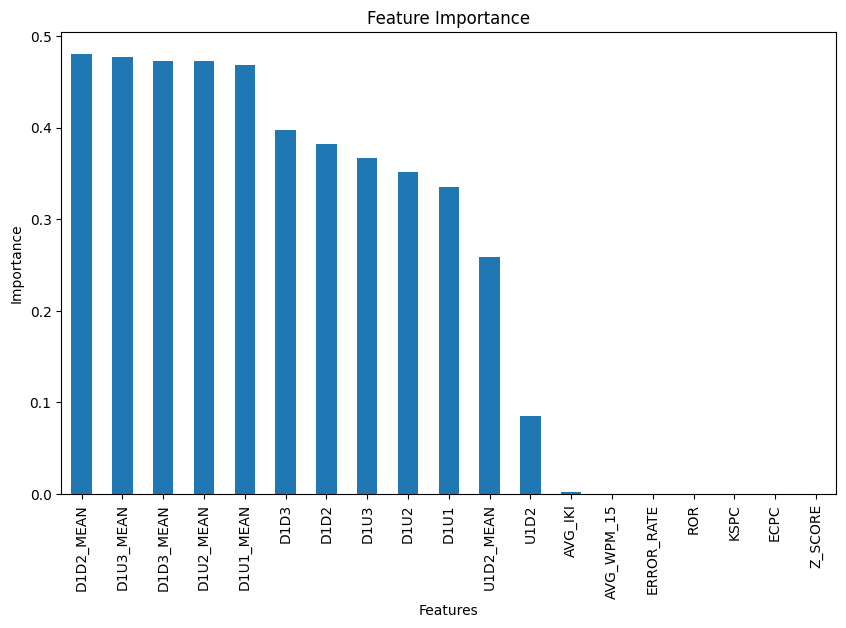

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt


def visualize_feature_importance(csv_path):
    # Step 1: Read the CSV file
    df = pd.read_csv(csv_path)

    # Step 2: Preprocess data
    # Drop rows with missing values
    df = df.dropna()

    # Encode the 'GENDER' column
    label_encoder = LabelEncoder()
    df['GENDER'] = label_encoder.fit_transform(df['GENDER'])

    # Select specified features and target
    features = [
        'ERROR_RATE', 'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR', 'D1U1', 'D1U2', 'D1U3', 'D1D2', 'D1D3',
        'D1U1_MEAN',
        'D1U2_MEAN',
        'D1U3_MEAN', 'D1D2_MEAN', 'D1D3_MEAN', 'U1D2', 'U1D2_MEAN', 'Z_SCORE'
    ]
    X = df[features]
    y = df['GENDER']

    # Step 3: Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Step 4: Train KNN model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    # Step 5: Calculate feature importance using permutation importance
    result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    importance = result.importances_mean

    # Step 6: Visualize feature importance
    feature_importance = pd.Series(importance, index=features)
    feature_importance.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()


# Example usage:
csv_path = 'demo_keystroke.csv'  # Path to the CSV file
visualize_feature_importance(csv_path)

# 7.0 ANN

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Step 1: Read the CSV file
df = pd.read_csv('demographics_csv/male_female_balanced.csv')

# Step 2: Preprocess data
# Drop rows with missing values
df = df.dropna()

# Encode the 'GENDER' column
label_encoder = LabelEncoder()
df['GENDER'] = label_encoder.fit_transform(df['GENDER'])

# Select specified features and target
features = [
    'D1U1', 'D1U2', 'D1U3', 'D1D2', 'D1D3', 'Z_SCORE', 'U1D2', 'SPEED_CLASS', 'HAND_HOLD_TIME', 'KEY_HOLD_TIME_STD', 'HAND'
]
X = df[features]
y = df['GENDER']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convert target to categorical
y = to_categorical(y)

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build ANN model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 5: Train ANN model
model.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.2)

# Step 6: Evaluate model
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
y_test_classes = y_test.argmax(axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy:.2f}')

D:\Coding_Projects\erkd\.venv\lib\site-packages\IPython\core\interactiveshell.py:3508: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Epoch 1/20


D:\Coding_Projects\erkd\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6633/6633 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - accuracy: 0.5291 - loss: 0.6904 - val_accuracy: 0.5605 - val_loss: 0.6838
Epoch 2/20
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5554 - loss: 0.6847 - val_accuracy: 0.5775 - val_loss: 0.6794
Epoch 3/20
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 6s 965us/step - accuracy: 0.5785 - loss: 0.6793 - val_accuracy: 0.5965 - val_loss: 0.6725
Epoch 4/20
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 7s 995us/step - accuracy: 0.5895 - loss: 0.6735 - val_accuracy: 0.6034 - val_loss: 0.6700
Epoch 5/20
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 6s 931us/step - accuracy: 0.5951 - loss: 0.6699 - val_accuracy: 0.6041 - val_loss: 0.6673
Epoch 6/20
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - accuracy: 0.5962 - loss: 0.6691 - val_accuracy: 0.6017 - val_loss: 0.6661
Epoch 7/20
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 6s 923us/step - accuracy: 0.5972 - loss: 0.6679 - val_accuracy: 0.6016 - val_loss: 0.6648
Epoch 8/20
6633/6633 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6003 - loss: 0.6668 - va